<a href="https://colab.research.google.com/github/AraratRobotics/RL-Enabled-DQN-Space-Defenders/blob/main/RL_Enabled_DQN_Space_Invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
import sys
import random
import time
import pygame

In [31]:
# Initialize Pygame and the font module
pygame.init()

class SpaceInvadersEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}
    def __init__(self, render_mode=None, size=1):
        super(SpaceInvadersEnv, self).__init__()
        self.size = size
        # Initialize width and height
        self.width, self.height = 300 * size, 300 * size

        # Define the observation space as a Box space (RGB images, 3 color channels)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.height, self.width, 3),
            dtype=np.uint8
        )

        # Define your action space
        self.action_space = spaces.Discrete(4)  # 0: left, 1: right, 2: shoot, 3: no-op

        # Initialize your game state and variables here
        self.observation_surface = pygame.Surface((self.width, self.height)) # Setup a surface for rendering the observation
        self.invader_img = pygame.image.load("/content/drive/MyDrive/Colab Notebooks/spaceInvadersEnvV7/invader.png")
        self.player_img = pygame.image.load("/content/drive/MyDrive/Colab Notebooks/spaceInvadersEnvV7/player.png")
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()
        self.player = pygame.Rect(self.width // 2 - 5 * size, self.height - 10 * size, 10 * size, 10 * size)
        self.current_level = 0
        self.max_levels = 5
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0
        self.done = False
        self.collision_detected = False
        self.invaders = []
        self.bullets = []
        self.create_invaders()

    def step(self, action):
        # Check if the episode is done
        self.done = self.current_level == self.max_levels
        #if self.done:  # If the game is over, no further action should be taken.
          #  return self._get_observation(), 0, True
        #self.collision_detected = False
        # Take a step in the game based on the chosen action
        if action == 0 and self.player.x > 0:
            # Move left
            self.player.x -= 3
            self.moved_left_count += 1
        elif action == 1 and self.player.x < self.width - self.player.width:
            # Move right
            self.player.x += 3
            self.moved_right_count += 1
        elif action == 2:
            # Shoot
            self.fire_bullet()
            self.shot_bullet_count += 1

        elif action == 3:
            # No-op (no operation)
            pass

        # Move the bullets
        self.bullets = [bullet for bullet in self.bullets if bullet.y >= 0]  # Keep bullets not off-screen
        for bullet in self.bullets[:]:  # Use a slice copy to iterate over the bullets
            bullet.y -= 5  # Move the bullet up by 5 units (adjust as necessary)
            if bullet.y < 0:  # If the bullet is off the screen (y < 0)
                self.bullets.remove(bullet)  # Remove it from the bullets list

        # Move the invaders
        for invader in self.invaders:
            invader['y'] += 0.2
            if invader['y'] + invader['height'] >= self.height:
                self.done = True
                break

        # Check Collision
        for bullet in self.bullets[:]:  # Iterate over a copy of the bullets list
            for invader in self.invaders[:]:  # Iterate over a copy of the invaders list
                # Check if the bullet is within the horizontal bounds of the invader
                if bullet.x >= invader['x'] and bullet.x <= invader['x'] + invader['width']:
                    # Check if the bullet is within the vertical bounds of the invader
                    if bullet.y >= invader['y'] and bullet.y <= invader['y'] + invader['height']:
                        # Collision detected, remove bullet and invader, increment counter
                        self.bullets.remove(bullet)
                        self.invaders.remove(invader)
                        self.collision_detected = True
                        self.invaders_destroyed += 1
                        break  # Exit the inner loop to avoid modifying the list during iteration

        # Respawn invaders if all are dead
        if not self.invaders and not self.done:
            self.current_level += 1
            self.create_invaders()

        reward = self._compute_reward()

        return self._get_observation(), reward, self.done

    def _get_observation(self):
        self.observation_surface.fill((0, 0, 0))  # Clear the surface
        self.draw_player(self.observation_surface)
        self.draw_invaders(self.observation_surface)
        self.draw_bullets(self.observation_surface)
        observation = pygame.surfarray.array3d(self.observation_surface)
        observation = np.transpose(observation, (1, 0, 2))  # Transpose to get the correct orientation
        return observation

    def reset(self):
        # Reset episode-specific variables
        self.player = pygame.Rect(self.width // 2 - 5 * self.size, self.height - 10 * self.size, 10 * self.size, 10 * self.size)
        self.current_level = 0
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0
        self.done = False
        self.collision_detected = False
        self.invaders = []
        self.bullets = []
        # Create a new set of invaders
        self.create_invaders()

        # Return the initial observation
        return self._get_observation()

    def draw_player(self, surface):
        player_img = pygame.transform.scale(self.player_img, (10 * self.size, 10 * self.size))
        surface.blit(player_img, (self.player.x, self.player.y))

    def draw_invaders(self, surface):
        for invader in self.invaders:
            invader_img = pygame.transform.scale(self.invader_img, (invader['width'], invader['height']))
            surface.blit(invader_img, (invader['x'], invader['y']))

    def draw_bullets(self, surface):
        for bullet in self.bullets:
            pygame.draw.rect(surface, (255, 255, 255), bullet)

    def create_invaders(self):
        self.invaders.clear()
        max_invaders = 10
        for _ in range(max_invaders):
            invader = {
                'x': random.uniform(10, self.width - 10),
                'y': random.uniform(-200, 0),
                'width': 10 * self.size,
                'height': 10 * self.size,
            }
            self.invaders.append(invader)

    def fire_bullet(self):
        bullet = pygame.Rect(self.player.x + self.player.width // 2, self.player.y, 2 * self.size, 3 * self.size)
        self.bullets.append(bullet)

    def _compute_reward(self):
        # Initialize the reward for this step
        step_reward = 0

        # Add reward for destroyed invaders
        step_reward += self.invaders_destroyed * 15  # Assuming a reward of 10 for each invader destroyed
        step_reward += self.moved_left_count * 0.5
        step_reward += self.moved_right_count * 0.5
        step_reward += self.shot_bullet_count * 0.001
        step_reward += self.current_level * 100
        #step_reward += (self.shot_bullet_count - self.invaders_destroyed) * -1
        # Subtract penalty for bullets that didn't hit anything
        # Assuming you keep track of bullets fired and invaders destroyed correctly
        #missed_shots = max(0, len(self.bullets) - self.invaders_destroyed)
        #step_reward -= missed_shots * 0.05  # Assuming a penalty of 0.05 for each missed shot

        # Reset the number of destroyed invaders after the reward is calculated
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0

        return step_reward

    def control_frame_rate(self, fps=120):
        self.clock.tick(fps)

    def render(self, mode='human'):
        if mode == 'human':
            # Clear the screen and draw the game state for human viewing
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.close()
            self.screen.fill((0, 0, 0))  # Replace with the desired background color
            self.draw_player(self.screen)
            self.draw_invaders(self.screen)
            self.draw_bullets(self.screen)
            pygame.display.flip()
        # Additional rendering modes can be handled here if needed
    def close(self):
        # Close the Pygame window
        pygame.quit()

In [6]:
def test_environment(env, num_episodes=10):
    for episode in range(num_episodes):
        done = False
        state = env.reset()
        total_reward = 0

        while not done:
            env.render()
            env.control_frame_rate(500)  # Control FPS

            action = env.action_space.sample()
            state, reward, done = env.step(action)
            total_reward += reward

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    env.close()

# Initialize your environment
env = SpaceInvadersEnv()

# Test the environment
test_environment(env)

Episode: 1, Total Reward: 59.357999999999706
Episode: 2, Total Reward: 81.3610000000003
Episode: 3, Total Reward: 9.379000000000067
Episode: 4, Total Reward: 64.5239999999998
Episode: 5, Total Reward: 74.40700000000086
Episode: 6, Total Reward: 75.39700000000065
Episode: 7, Total Reward: 82.8630000000003
Episode: 8, Total Reward: 42.88899999999965
Episode: 9, Total Reward: 94.8780000000003
Episode: 10, Total Reward: 19.453000000000042


In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [8]:
# Initialize environment
env = SpaceInvadersEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Named tuple for storing experiences
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# DQN architecture
class DQN(nn.Module):
    def __init__(self, observation, outputs):
        height, width, _ = observation
        print('Width initial', width)
        print('Height initial', height)
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=4)
        print('Width after conv1', width)
        print('Height after conv1', height)
        self.bn1 = nn.BatchNorm2d(8)
        print('Width after bn1', width)
        print('Height after bn1', height)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=4)
        print('Width after conv2', width)
        print('Height after conv2', height)
        self.bn2 = nn.BatchNorm2d(16)
        print('Width after bn2', width)
        print('Height after bn2', height)

        """self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        print('Width after conv3', width)
        print('Height after conv3', height)
        self.bn3 = nn.BatchNorm2d(32)
        print('Width after bn3', width)
        print('Height after bn3', height)"""

        def conv2d_size_out(size, kernel_size=5, stride=4):
            return (size - (kernel_size - 1) - 1) // stride + 1


        convw = conv2d_size_out(conv2d_size_out(width))
        print('convw', convw)
        convh = conv2d_size_out(conv2d_size_out(height))
        print('convw', convw)
        linear_input_size = convw * convh * 16
        print('Linear Input Size', linear_input_size)
        print('Outputs', outputs)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [10]:
# Hyperparameters
BATCH_SIZE = 50
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
LR = 1e-4

n_actions = env.action_space.n
observation = env.reset().shape

policy_net = DQN(observation, n_actions).to(device)
target_net = DQN(observation, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Width initial 300
Height initial 300
Width after conv1 300
Height after conv1 300
Width after bn1 300
Height after bn1 300
Width after conv2 300
Height after conv2 300
Width after bn2 300
Height after bn2 300
convw 18
convw 18
Linear Input Size 5184
Outputs 4
Width initial 300
Height initial 300
Width after conv1 300
Height after conv1 300
Width after bn1 300
Height after bn1 300
Width after conv2 300
Height after conv2 300
Width after bn2 300
Height after bn2 300
convw 18
convw 18
Linear Input Size 5184
Outputs 4


In [11]:
# Main training loop
num_episodes = 50
for i_episode in range(num_episodes):
    env.reset()
    state = env._get_observation()
    state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
    for t in count():
        action = select_action(state)
        observation, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = observation
            next_state = torch.from_numpy(next_state).permute(2, 0, 1).unsqueeze(0).to(device).float()
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Training complete')
#env.render()
#env.close()
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training complete
Complete


TypeError: ignored

<Figure size 640x480 with 0 Axes>

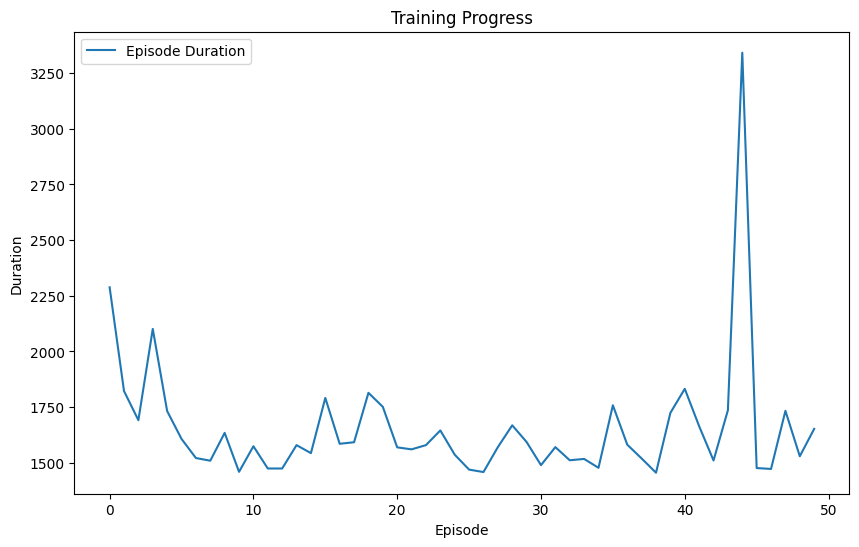

In [14]:
import matplotlib.pyplot as plt
import torch

def plot_durations(episode_durations):
    plt.figure(figsize=(10,6))
    plt.title("Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Duration")

    # Plot the actual durations
    plt.plot(episode_durations, label='Episode Duration')

    # Calculate and plot the rolling average
    if len(episode_durations) >= 100:
        means = torch.tensor(episode_durations, dtype=torch.float).unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='Rolling Average (last 100 episodes)')

    plt.legend()
    plt.show()

# Example usage (after training is complete):
# plot_durations(episode_durations)

# Call the plotting function with the recorded episode durations
plot_durations(episode_durations)

plt.ioff()
plt.show()

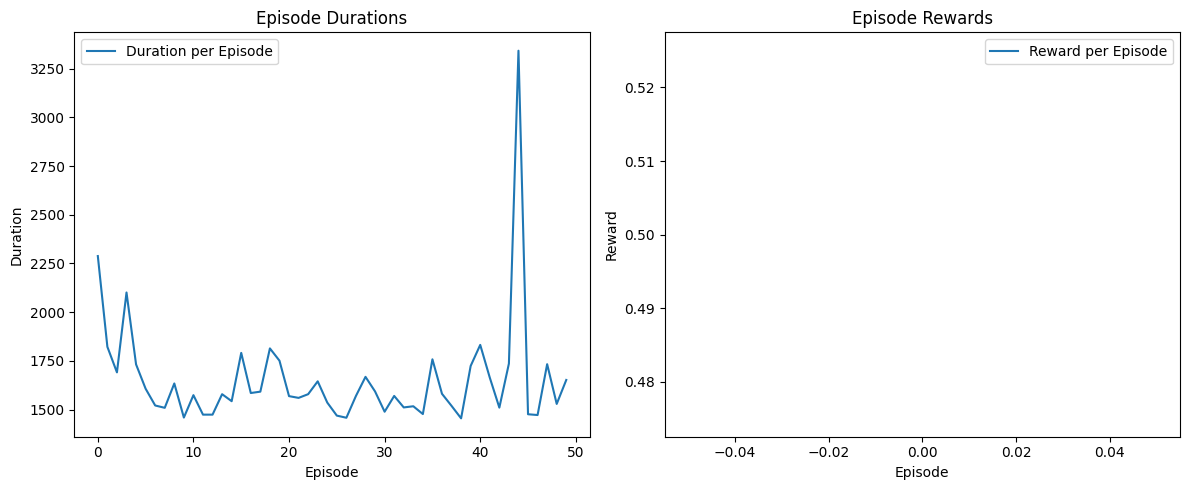

In [19]:
def plot_durations_and_rewards(episode_durations, episode_rewards):
    # Ensure rewards are on CPU and converted to list
    if isinstance(episode_rewards, torch.Tensor):
        episode_rewards = episode_rewards.cpu().tolist()

    plt.figure(figsize=(12, 5))

    # Plot episode durations
    plt.subplot(1, 2, 1)
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(episode_durations, label='Duration per Episode')
    plt.legend()

    # Plot episode rewards
    plt.subplot(1, 2, 2)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episode_rewards, label='Reward per Episode')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_durations_and_rewards(episode_durations, reward)

plt.ioff()
plt.show()

In [20]:
def test_environment(env, policy_net, num_episodes=100):
    policy_net.eval()  # Set the network to evaluation mode
    for episode in range(num_episodes):
        done = False
        state = env.reset()
        state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
        total_reward = 0

        while not done:
            env.render()
            env.control_frame_rate(500)  # Control FPS

            # Instead of randomly sampling an action, use the policy network
            action = policy_net(state).max(1)[1].view(1, 1)
            state, reward, done = env.step(action.item())
            state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
            total_reward += reward

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    env.close()

# Initialize your environment
env = SpaceInvadersEnv()

# Use the trained policy network for testing
test_environment(env, policy_net)

Episode: 1, Total Reward: 413.58699999999874
Episode: 2, Total Reward: 292.6969999999991
Episode: 3, Total Reward: -127.58499999999952
Episode: 4, Total Reward: -13.14599999999939
Episode: 5, Total Reward: -165.4959999999987
Episode: 6, Total Reward: 278.6220000000006
Episode: 7, Total Reward: 156.6819999999999
Episode: 8, Total Reward: -12.302000000000033
Episode: 9, Total Reward: 20.886999999998878
Episode: 10, Total Reward: 50.677000000000014
Episode: 11, Total Reward: 167.61600000000004
Episode: 12, Total Reward: 4.342000000000517
Episode: 13, Total Reward: -347.98900000000094
Episode: 14, Total Reward: 293.5
Episode: 15, Total Reward: 236.30400000000145
Episode: 16, Total Reward: -11.312999999999775
Episode: 17, Total Reward: 262.56499999999926
Episode: 18, Total Reward: -155.51299999999918
Episode: 19, Total Reward: 66.81200000000032
Episode: 20, Total Reward: 176.61800000000045
Episode: 21, Total Reward: 74.3160000000003
Episode: 22, Total Reward: 269.58900000000006
Episode: 23,

Episode: 1, Agent: trained, Total Reward: 95.72800000000055, Duration: 1477
Episode: 2, Agent: trained, Total Reward: 212.07800000000037, Duration: 1483
Episode: 3, Agent: trained, Total Reward: 142.70100000000096, Duration: 1511
Episode: 4, Agent: trained, Total Reward: 165.30100000000076, Duration: 1816
Episode: 5, Agent: trained, Total Reward: -100.67499999999927, Duration: 1486
Episode: 6, Agent: trained, Total Reward: 168.6270000000006, Duration: 1608
Episode: 7, Agent: trained, Total Reward: 9.753000000000034, Duration: 1482
Episode: 8, Agent: trained, Total Reward: 368.55200000000025, Duration: 1527
Episode: 9, Agent: trained, Total Reward: 247.1580000000005, Duration: 1643
Episode: 10, Agent: trained, Total Reward: 151.0, Duration: 1506
Episode: 11, Agent: trained, Total Reward: -1062.315000000018, Duration: 1476
Episode: 12, Agent: trained, Total Reward: 375.5, Duration: 1820
Episode: 13, Agent: trained, Total Reward: 17.769000000000382, Duration: 1661
Episode: 14, Agent: trai

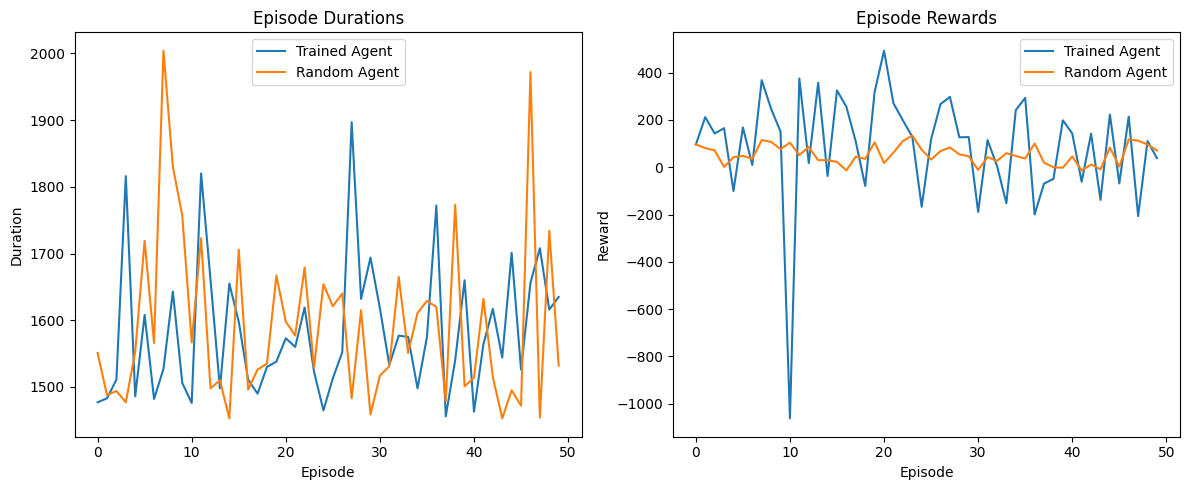

In [30]:
def test_environment(env, policy_net, agent_type='trained', num_episodes=5):
    rewards_per_episode = []
    durations_per_episode = []

    for episode in range(num_episodes):
        done = False
        state = env.reset()
        state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
        total_reward = 0
        steps = 0

        while not done:
            env.render()
            env.control_frame_rate(120)  # Control FPS to a reasonable rate

            if agent_type == 'trained':
                # Use the trained policy network to select an action
                action = policy_net(state).max(1)[1].view(1, 1)
            elif agent_type == 'random':
                # Sample a random action from the action space
                action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

            next_state, reward, done = env.step(action.item())
            next_state = torch.from_numpy(next_state).permute(2, 0, 1).unsqueeze(0).to(device).float()
            state = next_state
            total_reward += reward
            steps += 1

        rewards_per_episode.append(total_reward)
        durations_per_episode.append(steps)
        print(f"Episode: {episode + 1}, Agent: {agent_type}, Total Reward: {total_reward}, Duration: {steps}")

    env.close()
    return rewards_per_episode, durations_per_episode

# Initialize your environment
env = SpaceInvadersEnv()

# Use the trained policy network for testing
trained_rewards, trained_durations = test_environment(env, policy_net, agent_type='trained', num_episodes=50)

# Close and re-initialize Pygame and environment for the next test
env.close()
pygame.quit()
pygame.init()
env = SpaceInvadersEnv()  # Recreate the environment

# Test with a random policy
random_rewards, random_durations = test_environment(env, policy_net, agent_type='random', num_episodes=50)

# Now you can compare the rewards and durations between the trained agent and random agent
# You could use plotting functions here to visualize the comparison

# Plot the results
plt.figure(figsize=(12, 5))

# Plot durations
plt.subplot(1, 2, 1)
plt.plot(trained_durations, label='Trained Agent')
plt.plot(random_durations, label='Random Agent')
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.legend()

# Plot rewards
plt.subplot(1, 2, 2)
plt.plot(trained_rewards, label='Trained Agent')
plt.plot(random_rewards, label='Random Agent')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()
